In [2]:
from collections import defaultdict
import logging
from typing import cast, Dict, List, Tuple, Union
from typing_extensions import get_args, Literal
import sys
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import yaml
import argparse
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial

from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl


from transformer_lens import HookedTransformer
from transformer_lens.utils import is_square
from transformer_lens.head_detector import (compute_head_attention_similarity_score, 
                      get_previous_token_head_detection_pattern, 
                      get_duplicate_token_head_detection_pattern,
                      get_induction_head_detection_pattern)



sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments/utils')
sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments')

from aheads import create_repeats_dataset


## TOY MODEL

In [93]:
class ToyModel(pl.LightningModule):
    def __init__(self, num_features: int, num_interm : int):
        super().__init__()
        self.save_hyperparameters()
        
        self.body = nn.Sequential(
            nn.Linear(num_features, num_interm),
            nn.ReLU(),
            nn.Linear(num_interm, num_interm),
            nn.ReLU(),
            nn.Linear(num_interm, num_interm),
            nn.ReLU(),
            nn.Linear(num_interm, 1, bias=False)
            )
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-2)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", logs["acc"], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss, "train_loss": logs["acc"]}
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch)
        self.log("val_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", logs["acc"], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss, "val_acc": logs["acc"]}
    
    def step(self, batch):
        x, y = batch
        logits = self.forward(x)
        loss = F.binary_cross_entropy(torch.sigmoid(logits), y)
        acc = ((logits.squeeze() > 0.5).float() == y.squeeze()).float().mean()
        return loss, {"loss": loss.item(), "acc": acc.item()}
    
    def forward(self, x):
        if isinstance(x, list):
            x, _ = x
        return self.body(x)

In [108]:
## generation hyperparameters

size = 10000
m1, m2, m3, m4 = 0, 1, 2, 3
s1, s2, s3, s4 = 1, 1, 1, 1
N, N_p, N_pp = 0, 2, 3
vec_size = 4

epochs = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

* Train on disambiguated data to detect mean m1
* Train on diambiguated data to detect whole task
* Check whether data is split by mean m1

In [109]:
def generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=True, disamb=True):
    f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
    f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
    f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
    f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
    if init_task:
        full = torch.concat([f1, f2, f3, f4], dim=1) 
        label = (torch.mean(f1) > N)
        alt_label = (torch.mean(f1) > N)
    else:
        full = torch.concat([f1, f2, f3, f4], dim=1) 
        label = (torch.mean(f3) > N_p) if (torch.mean(f1) > N) else (torch.mean(f4) > N_pp)
        alt_label = (torch.mean(f3) > N_p) if (torch.mean(f2) > N) else (torch.mean(f4) > N_pp)
    return full, label, alt_label

In [110]:
inputs = []
labels = []
alt_labels = []

for i in (range(size)):
    input, label, alt_label = generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=True)
    inputs.append(input)
    labels.append(label)
    alt_labels.append(alt_label)
    
inputs = torch.vstack(inputs)
labels = torch.vstack(labels).float()
alt_labels = torch.vstack(alt_labels).float()

In [111]:
train_size = int(0.8 * len(inputs))

inputs_t, labels_t, alt_labels_t = inputs[:train_size], labels[:train_size], alt_labels[:train_size]
inputs_v, labels_v, alt_labels_v = inputs[train_size:], labels[train_size:], alt_labels[train_size:]

train_dataset = TensorDataset(inputs_t.detach(), labels_t.view(-1, 1))
val_dataset = TensorDataset(inputs_v.detach(), labels_v.view(-1, 1))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

toy_model = ToyModel(inputs_t.shape[1], 128).to(device)
trainer = Trainer(max_epochs=epochs)
trainer.fit(toy_model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | body | Sequential | 35.3 K
------------------------------------
35.3 K    Trainable params
0         Non-trainable params
35.3 K    Total params
0.141     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [112]:
trainer.validate(toy_model, val_dataloader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9800000190734863     │
│      val_loss_epoch       │   0.042720671743154526    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.042720671743154526, 'val_acc_epoch': 0.9800000190734863}]

## Can't do the task it seems without greater than baseline accuracy

In [113]:
m2 = 0
## change mean m2 to be same as m1 -> otherwise, could just make the same

inputs = []
labels = []
alt_labels = []

for i in (range(size)):
    input, label, alt_label = generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=False)
    inputs.append(input)
    labels.append(label)
    alt_labels.append(alt_label)
    
inputs = torch.vstack(inputs)
labels = torch.vstack(labels).float()
alt_labels = torch.vstack(alt_labels).float()

In [114]:
train_size = int(0.8 * len(inputs))

inputs_t, labels_t, alt_labels_t = inputs[:train_size], labels[:train_size], alt_labels[:train_size]
inputs_v, labels_v, alt_labels_v = inputs[train_size:], labels[train_size:], alt_labels[train_size:]

train_dataset = TensorDataset(inputs_t.detach(), labels_t.view(-1, 1))
val_dataset = TensorDataset(inputs_v.detach(), labels_v.view(-1, 1))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

toy_model = ToyModel(inputs_t.shape[1], 128).to(device)
trainer = Trainer(max_epochs=epochs)
trainer.fit(toy_model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | body | Sequential | 35.3 K
------------------------------------
35.3 K    Trainable params
0         Non-trainable params
35.3 K    Total params
0.141     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [115]:
trainer.validate(toy_model, val_dataloader)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8845000267028809     │
│      val_loss_epoch       │    0.2965058982372284     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.2965058982372284, 'val_acc_epoch': 0.8845000267028809}]

In [116]:
toy_model.body[0]

Linear(in_features=16, out_features=128, bias=True)

In [131]:
m2 = 6
## disambiguate and check if learned f1 > N or nah

inputs_test = []
labels_test = []
alt_labels_test = []

for i in (range(int(size*0.2))):
    input_test, label_test, alt_label_test = generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=False)
    inputs_test.append(input_test)
    labels_test.append(label_test)
    alt_labels_test.append(alt_label_test)
    
inputs_test = torch.vstack(inputs_test)
labels_test = torch.vstack(labels_test).float()
alt_labels_test = torch.vstack(alt_labels_test).float()

In [132]:
disamb_learn = toy_model.body[0](inputs_test)

/tmp/ipykernel_3053437/961941304.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


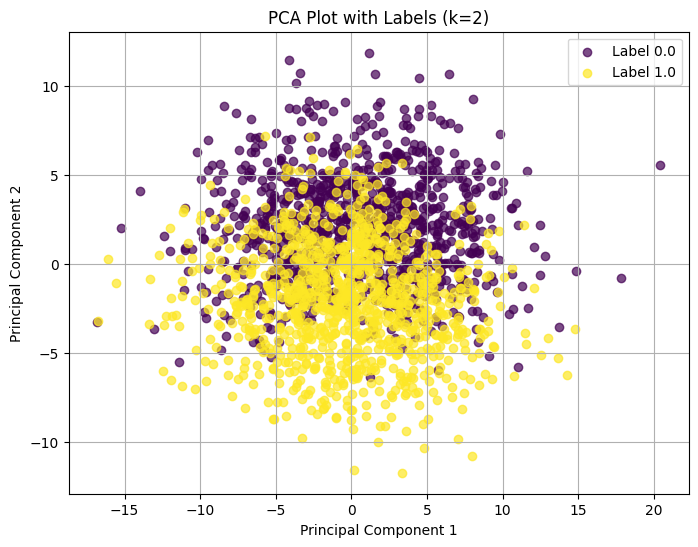

In [133]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

disamb_learn_numpy = disamb_learn.detach().numpy()

pca = PCA(n_components=2)
data_pca = pca.fit_transform(disamb_learn_numpy)

labels_numpy = labels_test.squeeze()

unique_labels = np.unique(labels_numpy)
colors = plt.cm.get_cmap('viridis', len(unique_labels))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    plt.scatter(data_pca[labels_numpy == label, 0], data_pca[labels_numpy == label, 1], 
                alpha=0.7, color=colors(i), label=f"Label {label}")

plt.title("PCA Plot with Labels (k=2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3053437/3662818271.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


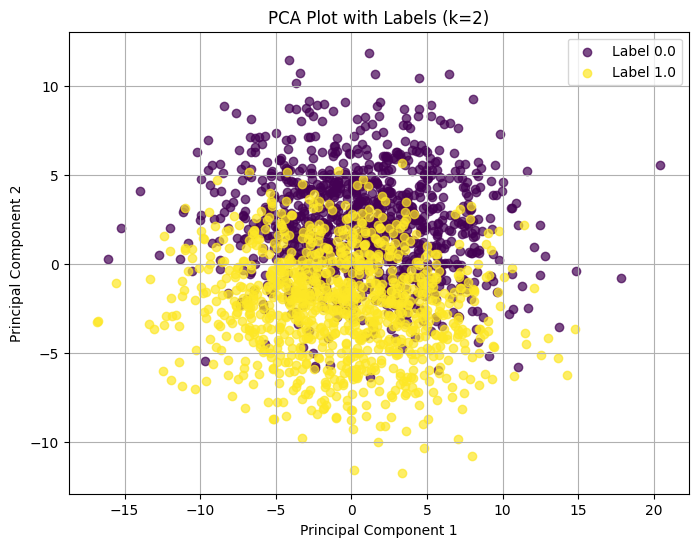

In [134]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

disamb_learn_numpy = disamb_learn.detach().numpy()

pca = PCA(n_components=2)
data_pca = pca.fit_transform(disamb_learn_numpy)

labels_numpy = alt_labels_test.squeeze()

unique_labels = np.unique(labels_numpy)
colors = plt.cm.get_cmap('viridis', len(unique_labels))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    plt.scatter(data_pca[labels_numpy == label, 0], data_pca[labels_numpy == label, 1], 
                alpha=0.7, color=colors(i), label=f"Label {label}")

plt.title("PCA Plot with Labels (k=2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [138]:
class Probe(pl.LightningModule):
    def __init__(self, num_features: int):
        super().__init__()
        self.save_hyperparameters()
        
        self.body = nn.Linear(num_features, 1, bias=False)
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-2)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, logs = self.step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", logs["acc"], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss, "train_loss": logs["acc"]}
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logs = self.step(batch)
        self.log("val_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", logs["acc"], on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss": loss, "val_acc": logs["acc"]}
    
    def step(self, batch):
        x, y = batch
        logits = self.forward(x)
        loss = F.binary_cross_entropy(torch.sigmoid(logits), y)
        acc = ((logits.squeeze() > 0.5).float() == y.squeeze()).float().mean()
        return loss, {"loss": loss.item(), "acc": acc.item()}
    
    def forward(self, x):
        if isinstance(x, list):
            x, _ = x
        return self.body(x)

In [139]:
train_size = int(0.8 * len(inputs_test))

inputs_t, labels_t, alt_labels_t = inputs_test[:train_size], labels_test[:train_size], alt_labels_test[:train_size]
inputs_v, labels_v, alt_labels_v = inputs_test[train_size:], labels_test[train_size:], alt_labels_test[train_size:]

train_dataset = TensorDataset(inputs_t.detach(), labels_t.view(-1, 1))
val_dataset = TensorDataset(inputs_v.detach(), labels_v.view(-1, 1))

train_dataset_alt = TensorDataset(inputs_t.detach(), alt_labels_t.view(-1, 1))
val_dataset_alt = TensorDataset(inputs_v.detach(), alt_labels_v.view(-1, 1))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_dataloader_alt = DataLoader(train_dataset_alt, batch_size=32, shuffle=True)
val_dataloader_alt = DataLoader(val_dataset_alt, batch_size=32, shuffle=False)

probe_labels = Probe(inputs_t.shape[1]).to(device)
probe_alt_labels = Probe(inputs_t.shape[1]).to(device)

In [140]:
trainer = Trainer(max_epochs=epochs)
trainer.fit(probe_labels, train_dataloader, val_dataloader)
trainer.validate(probe_labels, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 16    
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/users/sanand14/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/users/sanand14/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7049999833106995     │
│      val_loss_epoch       │    0.6265430450439453     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.6265430450439453, 'val_acc_epoch': 0.7049999833106995}]

In [141]:
trainer = Trainer(max_epochs=epochs)
trainer.fit(probe_alt_labels, train_dataloader_alt, val_dataloader_alt)
trainer.validate(probe_alt_labels, val_dataloader_alt)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 16    
--------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7825000286102295     │
│      val_loss_epoch       │    0.49614936113357544    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.49614936113357544, 'val_acc_epoch': 0.7825000286102295}]

## TRANSPLANTATION

In [5]:
PYTHIA_VOCAB_SIZE = 50277 #50304
N_LAYERS=12
MODEL = "EleutherAI/pythia-160m"
PYTHIA_CHECKPOINTS_OLD = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512] + list(range(1000, 143000 + 1, 10000)) + [143000]
PYTHIA_CHECKPOINTS = [512] + list(range(1000, 10000 + 1, 1000))

HeadName = Literal["previous_token_head", "duplicate_token_head", "induction_head"]
HEAD_NAMES = cast(List[HeadName], get_args(HeadName))

In [6]:
def create_repeats_dataset(num_samples=50, min_vector_size=5, max_vector_size=50, min_num_repeats=5, max_num_repeats=20, max_vocab=PYTHIA_VOCAB_SIZE):
  """Creates a dataset for the experiment."""
  dataset = []
  for _ in range(num_samples):
    vector_size = torch.randint(min_vector_size, max_vector_size, (1,)).item()
    num_repeats = torch.randint(min_num_repeats, max_num_repeats, (1,)).item()
    tokens = torch.randint(0, max_vocab, (1, vector_size))
    tokens = tokens.repeat((1, num_repeats))
    dataset.append(tokens)
  return dataset

In [7]:
dataset = torch.load('../outputs/aheads/dataset.pt')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def copy_attention_head(model1, model2, layer_idx, head_idx, dataset):
  if model1.isinstance(HookedTransformer) and model2.isinstance(HookedTransformer):
    model1.W_K.data[layer_idx, head_idx, :, :] = model2.W_K.data[layer_idx, head_idx, :, :]
    model1.W_Q.data[layer_idx, head_idx, :, :] = model2.W_Q.data[layer_idx, head_idx, :, :]
    model1.W_V.data[layer_idx, head_idx, :, :] = model2.W_V.data[layer_idx, head_idx, :, :]
    model1.b_K.data[layer_idx, head_idx, :] = model2.b_K.data[layer_idx, head_idx, :]
    model1.b_Q.data[layer_idx, head_idx, :] = model2.b_Q.data[layer_idx, head_idx, :]
    model1.b_V.data[layer_idx, head_idx, :] = model2.b_V.data[layer_idx, head_idx, :]
  else:
    model1.encoder.layers[layer_idx].self_attn.in_proj_weight.data[head_idx,:,:] = model2.encoder.layers[layer_idx].self_attn.in_proj_weight.data[head_idx,:,:]
  return perplexity(model1, dataset), perplexity(model2, dataset)


In [13]:
def calculate_perplexity(corpus, model, device="cpu"):
    encoded_input = model.to_tokens(corpus)
    encoded_input = encoded_input.to(device)
    with torch.no_grad():
      outputs = model(encoded_input).squeeze(0)
      loss = F.cross_entropy(outputs, encoded_input.squeeze(0), reduction='sum')/encoded_input.shape[1]
    perplexity = torch.exp(loss).item()
    return perplexity

In [15]:
def perplexity(model, dataset):
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
  with torch.no_grad():
    for batch in data_loader:
      inputs, targets = batch
      outputs = model(inputs)
      loss = F.cross_entropy(outputs, targets, reduction='sum')
      total_loss += loss.item()
    average_loss = total_loss / len(data_loader.dataset)
    return torch.exp(torch.tensor(average_loss))